In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
words = open("./data/names.txt").read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
letter_embedding_size = 10
block_size = 3
hidden_layer_size = 200

In [6]:
def build_dataset(words, block_size=3):
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
train_words, train_labels = build_dataset(words[:n1], block_size=block_size)
valid_words, valid_labels = build_dataset(words[n1:n2], block_size=block_size)
test_words, test_labels = build_dataset(words[n2:], block_size=block_size)


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
g = torch.Generator().manual_seed(42)
letter_embeddings = torch.randn(len(stoi), letter_embedding_size, generator=g)
W1 = torch.randn((block_size * letter_embedding_size, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, len(stoi)), generator=g)
b2 = torch.randn(len(stoi), generator=g)
parameters = [letter_embeddings, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

lossi = []

In [9]:
num_epochs = 200000
batch_size = 32
learning_rate = 0.1
for epoch in range(num_epochs):
    # choose batch_size random positions
    ix = torch.randint(0, train_words.shape[0], (batch_size,))
    emb = letter_embeddings[train_words[ix]]
    aux = emb.view(-1, block_size * letter_embedding_size)
    # forward pass
    output = torch.tanh(emb.view(-1, block_size * letter_embedding_size) @ W1 + b1)
    output = output @ W2 + b2
    loss = F.cross_entropy(output, train_labels[ix])

    # zero grad
    for p in parameters:
        p.grad = None

    # backward pass
    loss.backward()

    learning_rate = 0.1 if epoch < 10000 else 0.01
    # update gradients
    for p in parameters:
        p.data += -learning_rate * p.grad

    lossi.append(loss.item())

In [11]:
def accuracy(data, labels):
    emb = letter_embeddings[data]
    aux = emb.view(-1, block_size * letter_embedding_size)
    output = torch.tanh(aux @ W1 + b1)
    output = output @ W2 + b2
    loss = F.cross_entropy(output, labels)
    return loss.item()

In [12]:
print(f"Accuracy on train: {accuracy(train_words, train_labels)}")
print(f"Accuracy on valid: {accuracy(valid_words, valid_labels)}")
print(f"Accuracy on test: {accuracy(test_words, test_labels)}")

Accuracy on train: 2.235100507736206
Accuracy on valid: 2.247962236404419
Accuracy on test: 2.2563207149505615


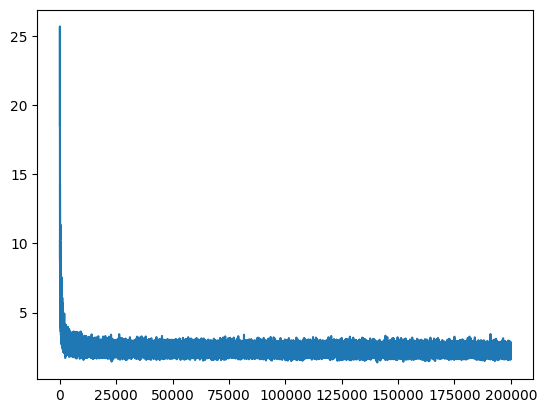

In [13]:
plt.plot(lossi)

In [21]:
for _ in range(10):

    out = []
    context = [0] * block_size
    while True:
        emb = letter_embeddings[torch.tensor(context)]
        output = torch.tanh(emb.view(-1, block_size * letter_embedding_size) @ W1 + b1)
        output = output @ W2 + b2
        probs = F.softmax(output, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out[:-1]))

enno
eleemmiah
ebonteand
quavrig
dayce
edholla
yem
akzilley
jelia
emir
